In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

### Adapting N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

### Utilities

In [8]:
function load_Ts(folder, nχ)
    ell_vector = sort!(npzread("ell_vector.npy")) 
    full_T = zeros(26, nχ, nχ, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        if isfile(filename)
            full_T[i,:,:,:] = npzread(filename)
        else
            full_T[i,:,:,:] = zeros(nχ,nχ,129)
        end
    end
    return full_T
end;

In [9]:
function plot_pmd(w, i, label,ell_list="ell_vector.npy")
    ell_vector = npzread("ell_vector.npy")
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ), $label")
    return plot(p, layout=(1,1))
end;

In [10]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
nχ = 100
χ = LinRange(26, 7000, nχ)
ℓ = sort!(npzread("ell_vector.npy"))

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

In [11]:
old_T_LL = load_Ts("working_Ts/T_tilde_LL", 100)
old_T_CL = load_Ts("working_Ts/T_tilde_CL", 100)
old_T_CC = load_Ts("working_Ts/T_tilde_CC", 100)

old_w_LL = Will.w_ell_tullio(coeff, old_T_LL)
old_w_CL = Will.w_ell_tullio(coeff, old_T_CL)
old_w_CC = Will.w_ell_tullio(coeff, old_T_CC);

In [12]:
nχ2 = 200
χ2 = LinRange(26, 7000, nχ2)

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff2 = zeros(nχ2,nχ2,n_cheb+1)
for i in 1:nχ2
    for j in i:nχ2
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ2[i],χ2[j]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff2[i,j,:] = c.coefs
        coeff2[j,i,:] = coeff2[i,j,:]
    end
end

In [13]:
new_T_LL = load_Ts("working_Ts/T_tilde_LL_200", nχ2)
new_T_CL = load_Ts("working_Ts/T_tilde_CL_200", nχ2)
new_T_CC = load_Ts("working_Ts/T_tilde_CC_200", nχ2)

new_w_LL = Will.w_ell_tullio(coeff2, new_T_LL)
new_w_CL = Will.w_ell_tullio(coeff2, new_T_CL)
new_w_CC = Will.w_ell_tullio(coeff2, new_T_CC);

In [14]:
nχ3 = 300
χ3 = LinRange(26, 7000, nχ3)

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff3 = zeros(nχ3,nχ3,n_cheb+1)
for i in 1:nχ3
    for j in i:nχ3
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ3[i],χ3[j]), log10(kmin), log10(kmax))
        coeff3[i,j,:] = c.coefs
        coeff3[j,i,:] = coeff3[i,j,:]
    end
end

In [15]:
T_LL_300 = load_Ts("working_Ts/T_tilde_LL_300", nχ3)
T_CL_300 = load_Ts("working_Ts/T_tilde_CL_300", nχ3)
T_CC_300 = load_Ts("working_Ts/T_tilde_CC_300", nχ3)

w_LL_300 = Will.w_ell_tullio(coeff3, T_LL_300)
w_CL_300 = Will.w_ell_tullio(coeff3, T_CL_300)
w_CC_300 = Will.w_ell_tullio(coeff3, T_CC_300);

In [16]:
nχ5 = 500
χ5 = LinRange(26, 7000, nχ5)

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff5 = zeros(nχ5,nχ5,n_cheb+1)
for i in 1:nχ5
    for j in i:nχ5
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ5[i],χ5[j]), log10(kmin), log10(kmax)); 
        coeff5[i,j,:] = c.coefs
        coeff5[j,i,:] = coeff5[i,j,:]
    end
end

In [17]:
T_LL_500 = load_Ts("T_tilde_LL", nχ5)
T_CL_500 = load_Ts("T_tilde_CL", nχ5)
T_CC_500 = load_Ts("T_tilde_CC", nχ5)

w_LL_500 = Will.w_ell_tullio(coeff5, T_LL_500)
w_CL_500 = Will.w_ell_tullio(coeff5, T_CL_500)
w_CC_500 = Will.w_ell_tullio(coeff5, T_CC_500);

#### a couple plots for safety

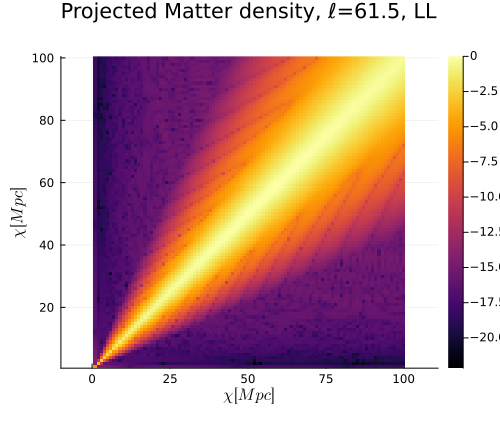

In [14]:
plots = []
for i in 10:10
    push!(plots, plot_pmd(old_w_LL, i, "LL"))
end

for plot in plots
    display(plot)
end

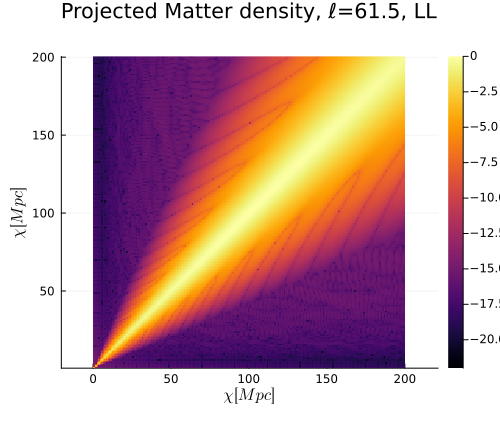

In [15]:
plots = []
for i in 10:10
    push!(plots, plot_pmd(new_w_LL, i, "LL"))
end

for plot in plots
    display(plot)
end

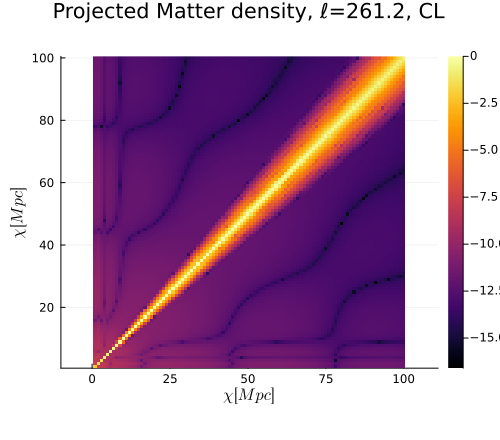

In [16]:
plots = []
for i in 20:20
    push!(plots, plot_pmd(old_w_CL, i, "CL"))
end

for plot in plots
    display(plot)
end

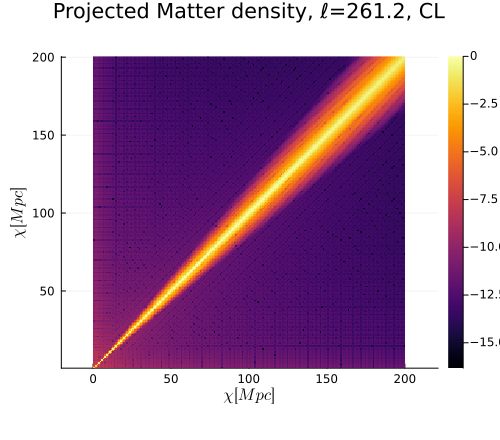

In [17]:
plots = []
for i in 20:20
    push!(plots, plot_pmd(new_w_CL, i, "CL"))
end

for plot in plots
    display(plot)
end

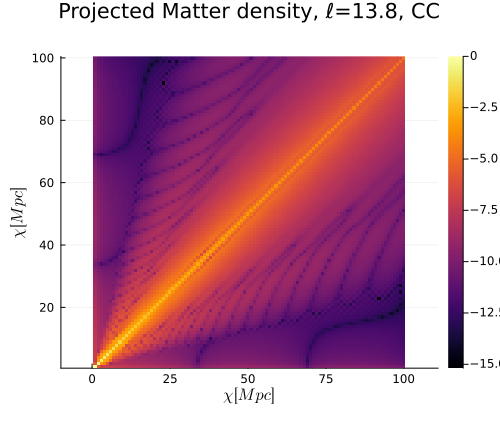

In [18]:
plots = []
for i in 5:5
    push!(plots, plot_pmd(old_w_CC, i, "CC"))
end

for plot in plots
    display(plot)
end

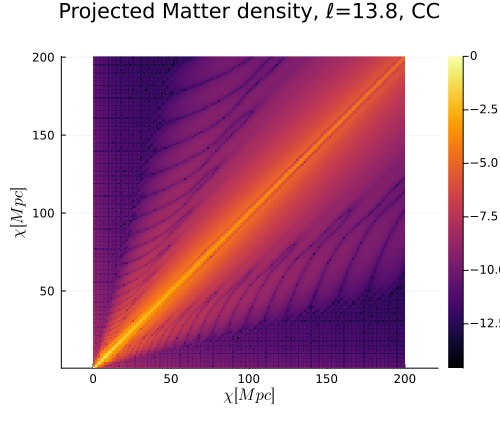

In [19]:
plots = []
for i in 5:5
    push!(plots, plot_pmd(new_w_CC, i, "CC"))
end

for plot in plots
    display(plot)
end

# $C_{\ell}$'s computation: $n\chi=100$

In [19]:
#Import window functions
W = npzread("../N5K/input/kernels_fullwidth.npz")
WA = W["kernels_sh"]
WB = W["kernels_cl"]
WA_interp = zeros(5,nχ)
WB_interp = zeros(10,nχ)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp[i,:] = interp.(χ)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp[i,:] = interp.(χ)
end;

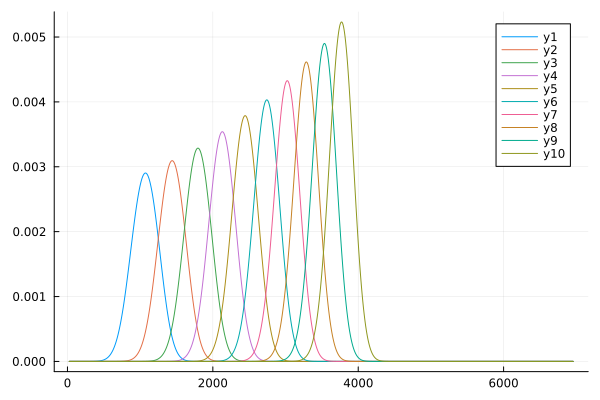

In [20]:
p = plot()
for i in 1:10
    plot!(p, W["chi_cl"], WB[i,:])
end
p

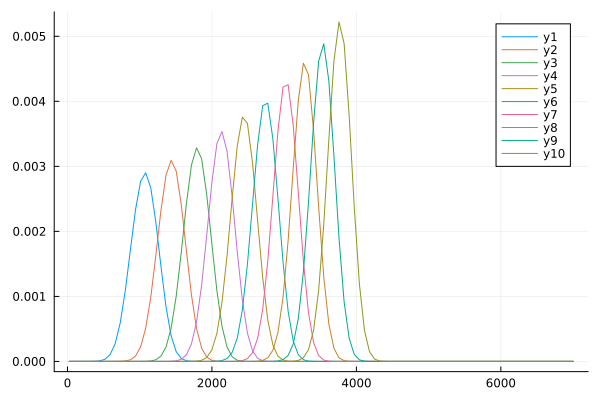

In [21]:
p = plot()
for i in 1:10
    plot!(p, χ, WB_interp[i,:])
end
p

In [22]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL = zeros(5,nχ)
for i in 1:size(WA_interp)[1]
    WA_LL[i,:] = WA_interp[i,:] ./ (Array(χ) .^ 2)
end;

In [23]:
function SimpsonWeightArray(n)
    number_intervals = floor((n-1)/2)
    weight_array = zeros(n)
    if n == number_intervals*2+1
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
    else
        weight_array[1] += 0.5
        weight_array[2] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)+1] += 1/3
            weight_array[Int((i-1)*2+2)+1] += 4/3
            weight_array[Int((i-1)*2+3)+1] += 1/3
        end
        weight_array[length(weight_array)]   += 0.5
        weight_array[length(weight_array)-1] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
        weight_array ./= 2
    end
    return weight_array
end;

In [24]:
function C_ell_computation_simpson(w, WA, WB)
    n = length(w[1,1,:])
    χ = LinRange(26, 7000, n)
    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = SimpsonWeightArray(n)
    @tullio int1[i,m,j] := Δχ*w[i,l,m]*WA[j,l]*pesi[l] 
    @tullio Cℓ[i,j,k] := Δχ*int1[i,m,j]*WB[k,m]*pesi[m]
end;

In [25]:
old_Cℓ_CC = C_ell_computation_simpson(old_w_CC, WB_interp, WB_interp);
old_Cℓ_LL = C_ell_computation_simpson(old_w_LL, WA_LL, WA_LL)
old_Cℓ_CL = C_ell_computation_simpson(old_w_CL, WA_LL, WB_interp);

In [26]:
# ADDING ELL PREFACTORS
old_Cℓ_CC = old_Cℓ_CC .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    old_Cℓ_LL[i,:,:] = old_Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    old_Cℓ_CL[i,:,:] = old_Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

#### Loading N5K stuff

In [27]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [28]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [29]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [30]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [31]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in i:5
        gl_reshaped[:,i,j] = gl[counter, :]
        gl_reshaped[:,j,i] = gl_reshaped[:,i,j]
        counter += 1
    end
end

## Let's take a loook

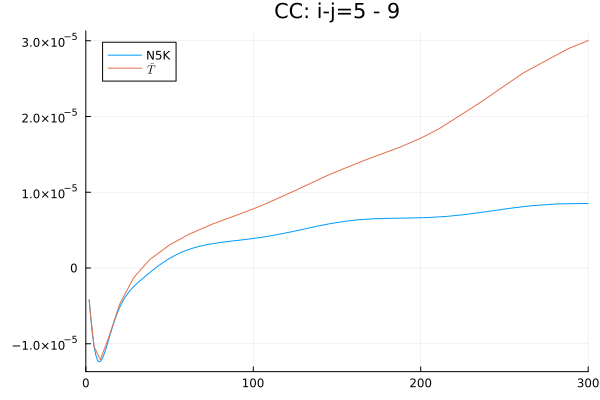

In [32]:
i = 5
j = 9
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, old_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$")
#plot!(ℓ, Cℓ_CC2[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ trap", legend=:bottomright)

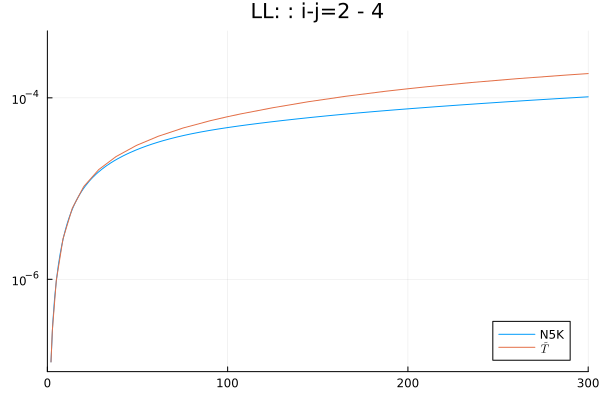

In [33]:
i = 2
j = 4
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$",legend=:bottomright)

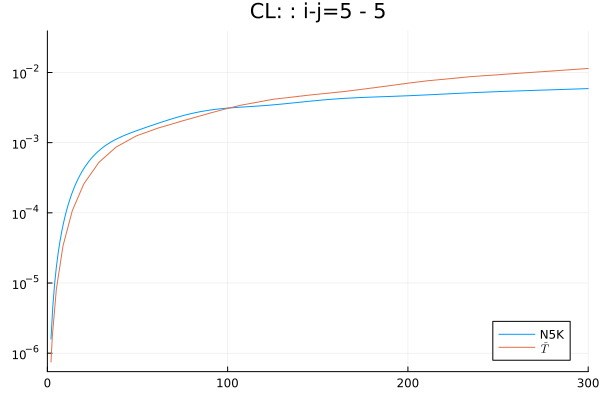

In [34]:
i = 5
j = 5
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, old_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$", legend=:bottomright)

# $C_{\ell}$'s computation: $n\chi=200$

In [35]:
#Import window functions
WA_interp2 = zeros(5,nχ2)
WB_interp2 = zeros(10,nχ2)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp2[i,:] = interp.(χ2)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp2[i,:] = interp.(χ2)
end;

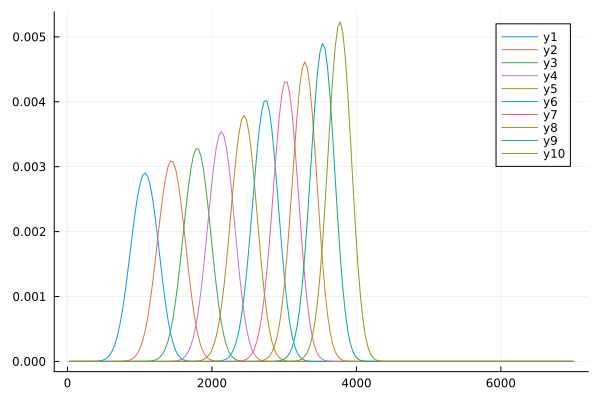

In [36]:
p = plot()
for i in 1:10
    plot!(p, χ2, WB_interp2[i,:])
end
p

In [37]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL2 = zeros(5,nχ2)
for i in 1:size(WA_interp2)[1]
    WA_LL2[i,:] = WA_interp2[i,:] ./ (Array(χ2) .^ 2)
end;

In [38]:
new_Cℓ_CC = C_ell_computation_simpson(new_w_CC, WB_interp2, WB_interp2);
new_Cℓ_LL = C_ell_computation_simpson(new_w_LL, WA_LL2, WA_LL2)
new_Cℓ_CL = C_ell_computation_simpson(new_w_CL, WA_LL2, WB_interp2);

In [39]:
# ADDING ELL PREFACTORS
new_Cℓ_CC = new_Cℓ_CC .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    new_Cℓ_LL[i,:,:] = new_Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    new_Cℓ_CL[i,:,:] = new_Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

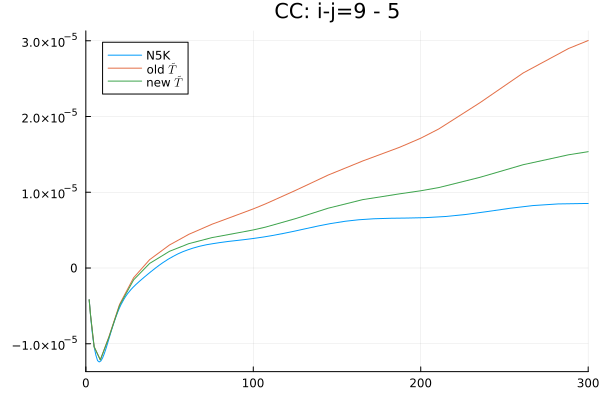

In [40]:
i = 9
j = 5
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, old_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$")
plot!(ℓ, new_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")

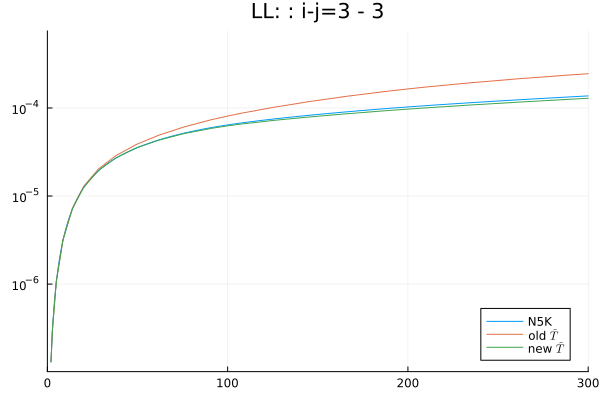

In [41]:
i = 3
j = 3
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$",legend=:bottomright)
plot!(ℓ, new_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")

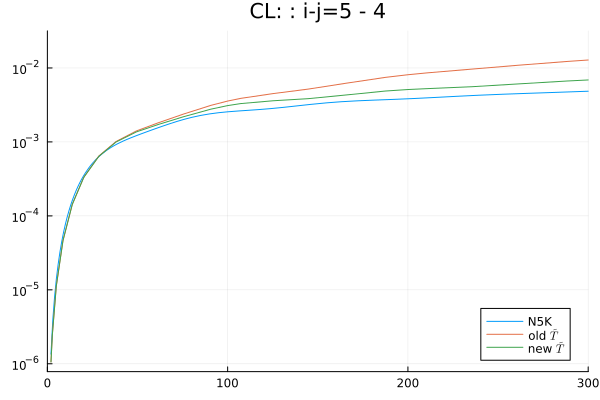

In [42]:
i = 5
j = 4
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, old_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$", legend=:bottomright)
plot!(ℓ, new_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")

# $C_{\ell}$'s computation: $n\chi=300$

In [43]:
#Import window functions
WA_interp3 = zeros(5,nχ3)
WB_interp3 = zeros(10,nχ3)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp3[i,:] = interp.(χ3)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp3[i,:] = interp.(χ3)
end;

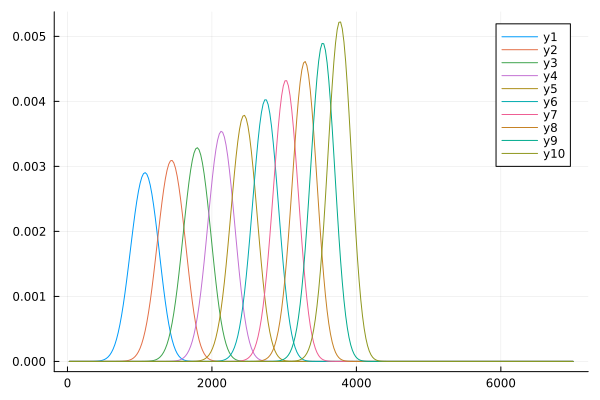

In [44]:
p = plot()
for i in 1:10
    plot!(p, χ3, WB_interp3[i,:])
end
p

In [45]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL3 = zeros(5,nχ3)
for i in 1:size(WA_interp3)[1]
    WA_LL3[i,:] = WA_interp3[i,:] ./ (Array(χ3) .^ 2)
end;

In [46]:
Cℓ_CC_300 = C_ell_computation_simpson(w_CC_300, WB_interp3, WB_interp3);
Cℓ_LL_300 = C_ell_computation_simpson(w_LL_300, WA_LL3, WA_LL3)
Cℓ_CL_300 = C_ell_computation_simpson(w_CL_300, WA_LL3, WB_interp3);

In [47]:
# ADDING ELL PREFACTORS
Cℓ_CC_300 = Cℓ_CC_300 .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    Cℓ_LL_300[i,:,:] = Cℓ_LL_300[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL_300[i,:,:] = Cℓ_CL_300[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

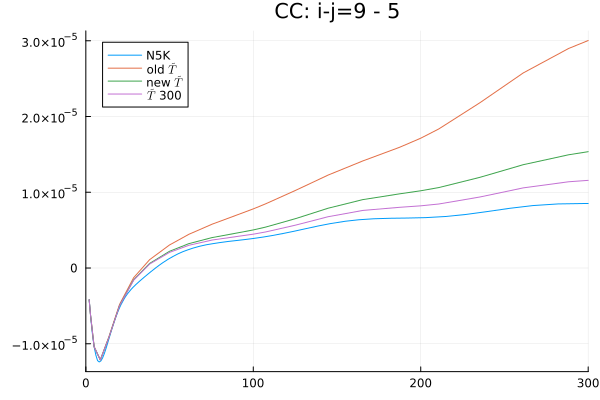

In [48]:
i = 9
j = 5
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, old_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$")
plot!(ℓ, new_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_CC_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")

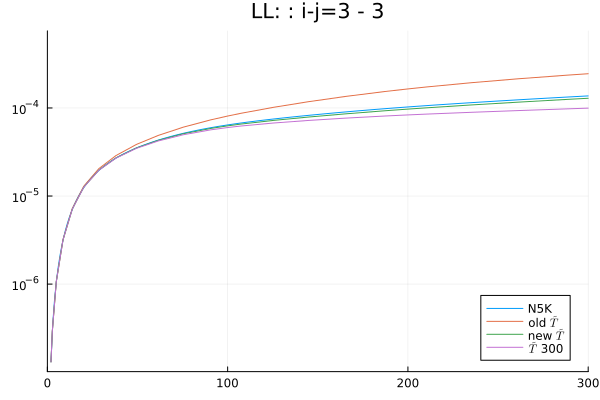

In [49]:
i = 3
j = 3
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$",legend=:bottomright)
plot!(ℓ, new_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_LL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")

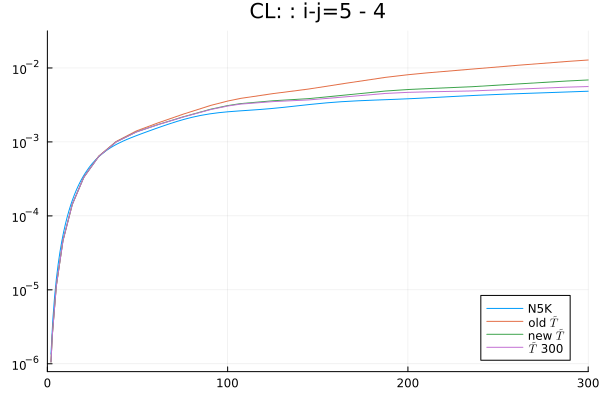

In [50]:
i = 5
j = 4
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, old_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$", legend=:bottomright)
plot!(ℓ, new_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_CL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")

# $C_{\ell}$'s computation: $n\chi=500$

In [51]:
#Import window functions
WA_interp5 = zeros(5,nχ5)
WB_interp5 = zeros(10,nχ5)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp5[i,:] = interp.(χ5)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp5[i,:] = interp.(χ5)
end;

In [52]:
# ADDING CHI FACTORS TO LENSING WINDOW FUNCTIONS
WA_LL5 = zeros(5,nχ5)
for i in 1:size(WA_interp5)[1]
    WA_LL5[i,:] = WA_interp5[i,:] ./ (Array(χ5) .^ 2)
end;

In [53]:
Cℓ_CC_500 = C_ell_computation_simpson(w_CC_500, WB_interp5, WB_interp5);
Cℓ_LL_500 = C_ell_computation_simpson(w_LL_500, WA_LL5, WA_LL5)
Cℓ_CL_500 = C_ell_computation_simpson(w_CL_500, WA_LL5, WB_interp5);

In [54]:
# ADDING ELL PREFACTORS
Cℓ_CC_500 = Cℓ_CC_500 .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

ell_vector = sort!(npzread("ell_vector.npy"))
for i in 1:length(ell_vector)
    Cℓ_LL_500[i,:,:] = Cℓ_LL_500[i,:,:] .* 2 .* factorial_frac(ell_vector[i]) ./ π
    Cℓ_CL_500[i,:,:] = Cℓ_CL_500[i,:,:] .* 2 .* sqrt.(factorial_frac(ell_vector[i])) ./ π
end

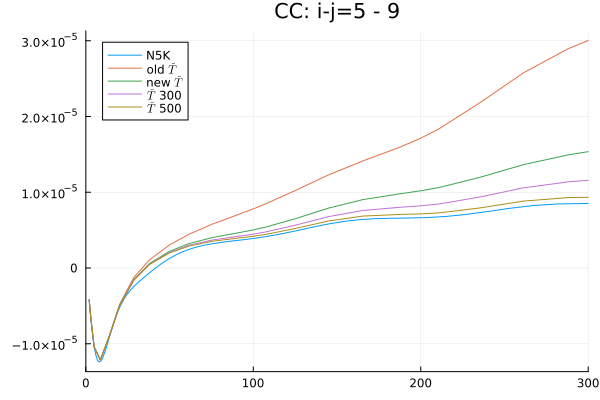

In [70]:
i = 5
j = 9
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, old_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$")
plot!(ℓ, new_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_CC_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_CC_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")

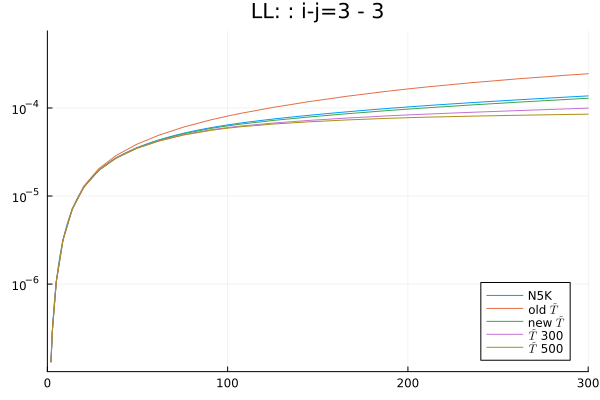

In [57]:
i = 3
j = 3
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$",legend=:bottomright)
plot!(ℓ, new_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_LL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_LL_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")

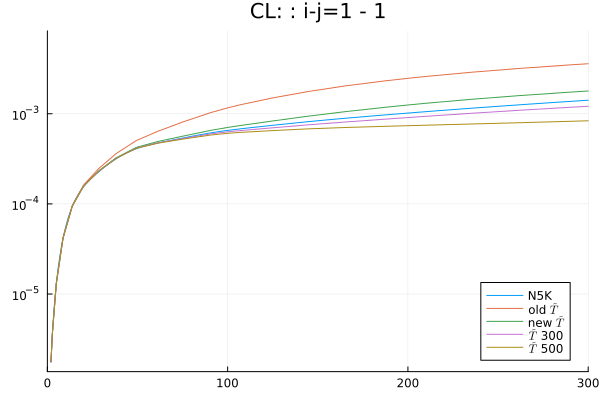

In [68]:
i = 1
j = 1
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, old_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$", legend=:bottomright)
plot!(ℓ, new_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_CL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_CL_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")

# Look into w with 2-FAST

In [96]:
function load_w_2F(label)
    ell_list = [2, 20,50, 100, 200,300]
    w = zeros(6, 200, 200)
    for (lidx, l) in enumerate(ell_list)
        filename = "w_2_FAST/w_$(label)_l_$l.npz"
        w[lidx,:,:] = npzread(filename)
    end
    return w
end;

In [97]:
w_2F_LL = load_w_2F("LL");
w_2F_CL = load_w_2F("CL")
w_2F_CC = load_w_2F("CC");

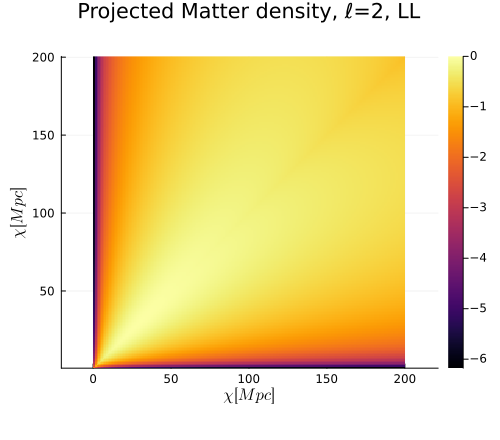

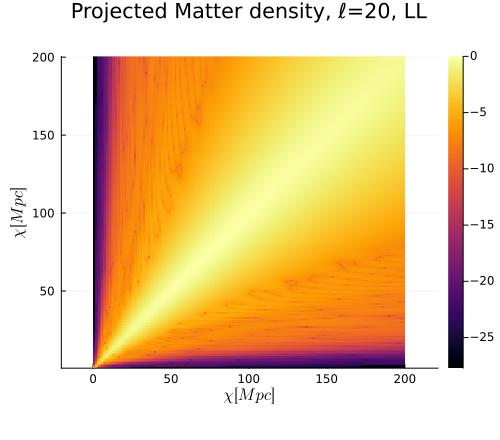

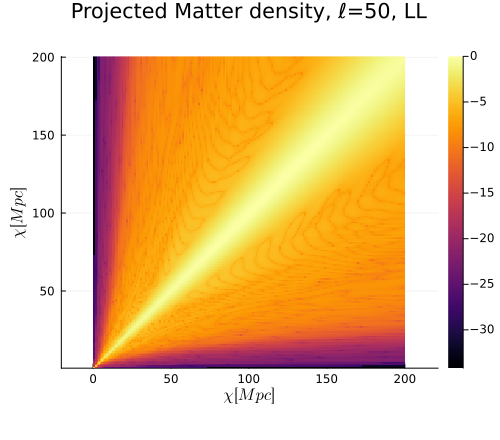

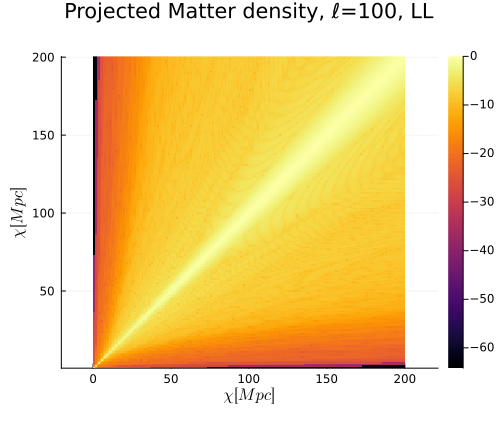

In [98]:
ℓ_2F = [2,20,50,100,200,300]
plots = []
for i in 1:4
    
    push!(plots, heatmap(log10.(abs.(w_2F_LL[i,:,:]./maximum(w_2F_LL[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ_2F[i]), LL"))
end

for plot in plots
    display(plot)
end

In [99]:
Cℓ_CC_2F = C_ell_computation_simpson(w_2F_CC, WB_interp2, WB_interp2);
Cℓ_LL_2F = C_ell_computation_simpson(w_2F_LL, WA_LL2, WA_LL2);
Cℓ_CL_2F = C_ell_computation_simpson(w_2F_CL, WA_LL2, WB_interp2);

In [100]:
# ADDING ELL PREFACTORS
Cℓ_CC_2F = Cℓ_CC_2F .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

for i in 1:length(ℓ_2F)
    Cℓ_LL_2F[i,:,:] = Cℓ_LL_2F[i,:,:] .* 2 .* factorial_frac(ℓ_2F[i]) ./ π
    Cℓ_CL_2F[i,:,:] = Cℓ_CL_2F[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ_2F[i])) ./ π
end

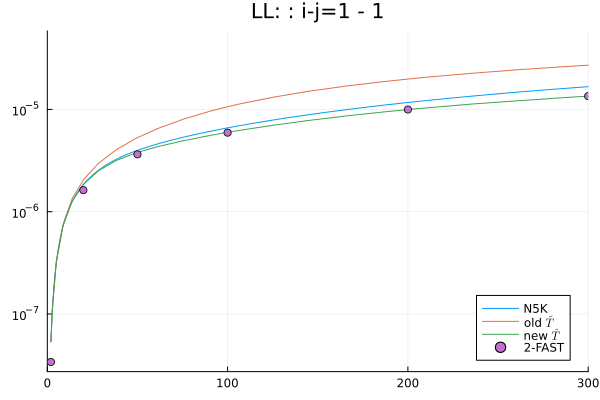

In [101]:
i = 1
j = 1
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$",legend=:bottomright)
plot!(ℓ, new_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
scatter!(ℓ_2F, Cℓ_LL_2F[:,i,j] .* ℓ_2F .* (ℓ_2F .+ 1) , label = "2-FAST")

# LIMBER APPROXIMATION

The integral i want to compuet now is $$C_\ell^{AB} = F^{AB}_{\ell}\int \frac{d\chi}{\chi^2} W^A(\chi)W^B(\chi)P_{AB}\left(k=\frac{\ell+0.5}{\chi}, z\right)$$

In [61]:
function power_spectrum_limber(ℓ, χ)
    k = (ℓ+0.5) ./ χ
    return @. 10^InterpPmm(z_of_χ(χ),log10(k)) 
end;

In [62]:
function Cℓ_limber(ℓ, χ, tracers)
    n = length(χ)
    W = npzread("../N5K/input/kernels_fullwidth.npz")
    WA = W["kernels_sh"]
    WB = W["kernels_cl"]
    WA_interp = zeros(5,n)
    WB_interp = zeros(10,n)
    
    for i in 1:5
        interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
        WA_interp[i,:] = interp.(χ)
    end
    
    for i in 1:10
        interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
        WB_interp[i,:] = interp.(χ)
    end

    if tracers == "CC"
        F = 1
        KA = WB_interp
        KB = WB_interp
    elseif tracers == "CL"
        F = sqrt.(factorial_frac(ℓ))*(ℓ+0.5)^(-2)
        KA = WB_interp
        KB = WA_interp
    elseif tracers == "LL"
        F = factorial_frac(ℓ)*(ℓ+0.5)^(-4)
        KA = WA_interp
        KB = WA_interp
    end

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = SimpsonWeightArray(n)

    pk_over_chi = power_spectrum_limber(ℓ, χ) ./ (χ .^ 2)
    
    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]
    return Cℓ
end;

In [63]:
Cℓ_CC_limb = zeros(26,10,10)
Cℓ_CL_limb = zeros(26,10,5)
Cℓ_LL_limb = zeros(26,5,5)

@time for (lindex, ell) in enumerate(ℓ)
    println("Processing ℓ=$(ell)")
    Cℓ_CL_limb[lindex,:,:] = Cℓ_limber(ell, LinRange(26,7000,500), "CL")
    Cℓ_CC_limb[lindex,:,:] = Cℓ_limber(ell, LinRange(26,7000,500), "CC")
    Cℓ_LL_limb[lindex,:,:] = Cℓ_limber(ell, LinRange(26,7000,500), "LL")
end   

Processing ℓ=2.0
Processing ℓ=2.739666011768332
Processing ℓ=4.957934086020933
Processing ℓ=8.652615059983086
Processing ℓ=13.820062729597831
Processing ℓ=20.0
Processing ℓ=20.455177447888648
Processing ℓ=28.551411157695608
Processing ℓ=38.10077385381776
Processing ℓ=49.093841468182184
Processing ℓ=50.0
Processing ℓ=61.51976517026251
Processing ℓ=75.36628207356486
Processing ℓ=90.61972733761604
Processing ℓ=100.0
Processing ℓ=107.26504765351123
Processing ℓ=125.2858160997126
Processing ℓ=144.664248353437
Processing ℓ=165.3812202416367
Processing ℓ=187.4162866142485
Processing ℓ=200.0
Processing ℓ=210.74770152108832
Processing ℓ=235.35243967247973
Processing ℓ=261.206219162432
Processing ℓ=288.28352543195393
Processing ℓ=300.0
171.738580 seconds (8.85 M allocations: 114.147 GiB, 30.45% gc time, 1.02% compilation time)


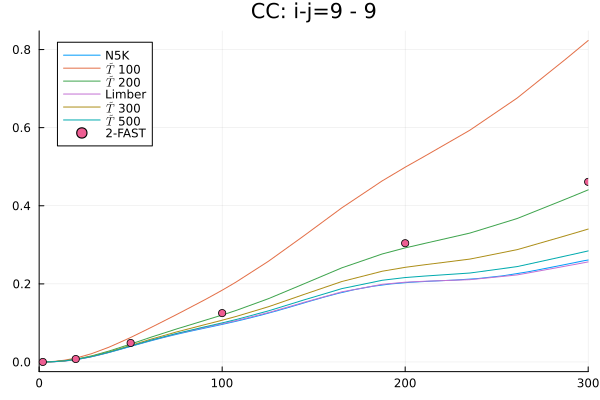

In [126]:
i = 9
j = 9
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, old_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 100")
plot!(ℓ, new_Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 200")
plot!(ℓ, Cℓ_CC_limb[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "Limber")
plot!(ℓ, Cℓ_CC_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_CC_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")
scatter!(ℓ_2F, Cℓ_CC_2F[:,i,j] .* ℓ_2F .* (ℓ_2F .+ 1) , label = "2-FAST")

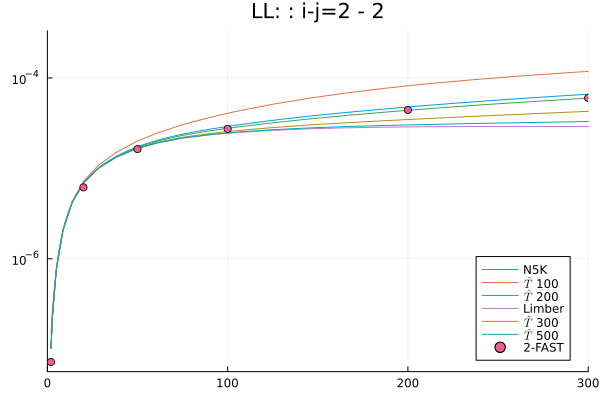

In [128]:
i = 2
j = 2
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, old_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 100",legend=:bottomright)
plot!(ℓ, new_Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 200")
plot!(ℓ, Cℓ_LL_limb[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "Limber")
plot!(ℓ, Cℓ_LL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_LL_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")
scatter!(ℓ_2F, Cℓ_LL_2F[:,i,j] .* ℓ_2F .* (ℓ_2F .+ 1) , label = "2-FAST")

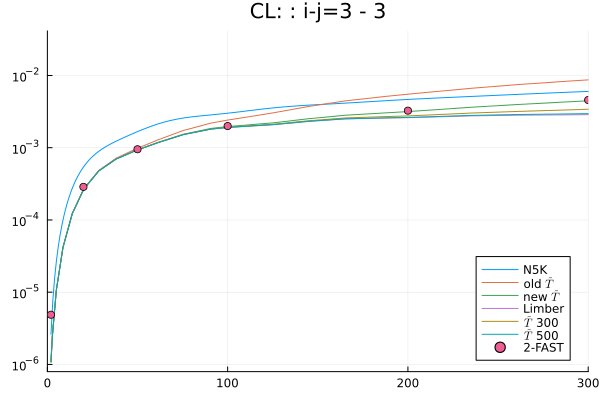

In [132]:
i = 3
j = 3
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300),yscale=:log10)
plot!(ℓ, old_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"old $\tilde T$", legend=:bottomright)
plot!(ℓ, new_Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"new $\tilde T$")
plot!(ℓ, Cℓ_CL_limb[:,i,j] .* ℓ .* (ℓ .+ 1) , label = "Limber")
plot!(ℓ, Cℓ_CL_300[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 300")
plot!(ℓ, Cℓ_CL_500[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$ 500")
scatter!(ℓ_2F, Cℓ_CL_2F[:,i,j] .* ℓ_2F .* (ℓ_2F .+ 1) , label = "2-FAST")

In [133]:
χ

100-element LinRange{Float64, Int64}:
 26.0, 96.4444, 166.889, 237.333, …, 6788.67, 6859.11, 6929.56, 7000.0

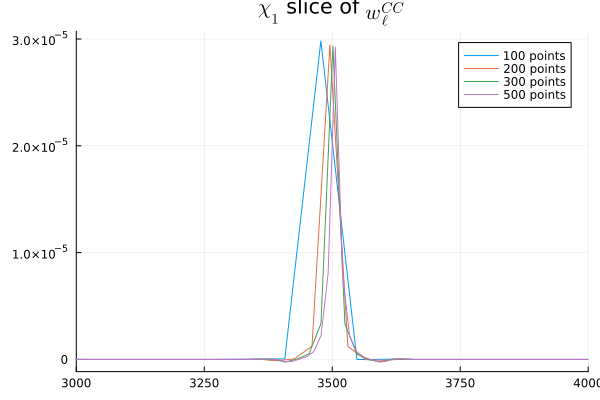

In [149]:
plot(χ, old_w_CC[26,50,:], label = "100 points", xlim=(3000,4000), title=L"$\chi_1$ slice of $w_{\ell}^{CC}$")
plot!(χ2, new_w_CC[26,100,:], label = "200 points")
plot!(χ3, w_CC_300[26,150,:], label = "300 points")
plot!(χ5, w_CC_500[26,250,:], label = "500 points")